<a href="https://colab.research.google.com/github/JoumanaMaki/Transfer-learning-and-fine-tuning-for-image-classification/blob/main/Transfer_Learning_and_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning and Fine Tuning for image classification

## Transfer Learning

### Importing Libraries

In [1]:
import tensorflow as tf
import zipfile
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator #used to read all the images in folder
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout # Input: input layer, GlobalAveragePooling2D: similar to flatten layer
from tensorflow.keras.models import Model # used to connect 2 neural networks the base and the new one therefore we didn't use Sequential
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
tf.__version__

'2.17.0'

### Loading the images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path ='/content/drive/MyDrive/Computer Vision Masterclass/Datasets/homer_bart_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

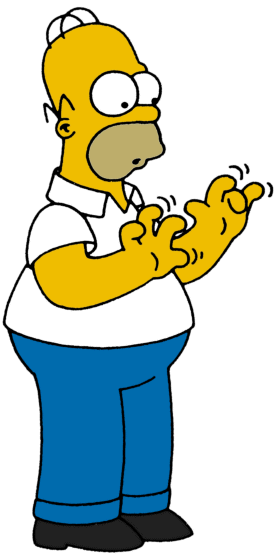

In [5]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/homer/homer100.bmp')

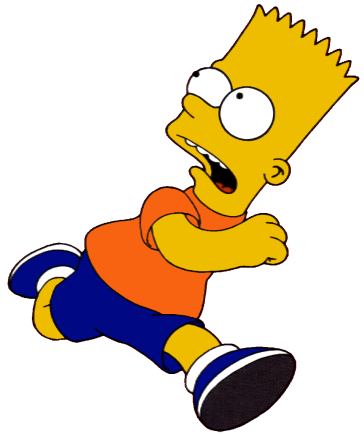

In [6]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart100.bmp')

### Train and test set

In [7]:
training_generator = ImageDataGenerator(
    rescale=1./255,   #rescale : value of pixels from 0 to 255 in order to norrmalize data
    rotation_range=7,
    zoom_range=0.2, #increase or decrease the zoom of the image
    horizontal_flip=True)

train_dataset = training_generator.flow_from_directory(
    directory='/content/homer_bart_2/training_set',
    target_size=(256,256),
    batch_size=8, # 8 by 8 images (mini batch gradient descent)
    class_mode='categorical',
shuffle = True)

Found 215 images belonging to 2 classes.


In [8]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [9]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [10]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(
    directory='/content/homer_bart_2/test_set',
    target_size=(256,256),
    batch_size=1,
    shuffle=  False,
    class_mode='categorical')

Found 54 images belonging to 2 classes.


### Pre-trained network

In [11]:
base_model = tf.keras.applications.ResNet50(
    include_top=False, # not using the dense part of the architecture
    weights='imagenet',
    input_shape=(256,256,3)) # same shape as train and test datasets

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
len(base_model.layers)

175

In [14]:
# need to freeye the weights of first layers
for layer in base_model.layers:
  print(layer, layer.trainable)
  layer.trainable = False

<InputLayer name=input_layer, built=True> True
<ZeroPadding2D name=conv1_pad, built=True> True
<Conv2D name=conv1_conv, built=True> True
<BatchNormalization name=conv1_bn, built=True> True
<Activation name=conv1_relu, built=True> True
<ZeroPadding2D name=pool1_pad, built=True> True
<MaxPooling2D name=pool1_pool, built=True> True
<Conv2D name=conv2_block1_1_conv, built=True> True
<BatchNormalization name=conv2_block1_1_bn, built=True> True
<Activation name=conv2_block1_1_relu, built=True> True
<Conv2D name=conv2_block1_2_conv, built=True> True
<BatchNormalization name=conv2_block1_2_bn, built=True> True
<Activation name=conv2_block1_2_relu, built=True> True
<Conv2D name=conv2_block1_0_conv, built=True> True
<Conv2D name=conv2_block1_3_conv, built=True> True
<BatchNormalization name=conv2_block1_0_bn, built=True> True
<BatchNormalization name=conv2_block1_3_bn, built=True> True
<Add name=conv2_block1_add, built=True> True
<Activation name=conv2_block1_out, built=True> True
<Conv2D name=c

In [15]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True> F

### Custom dense layer

In [16]:
#get the last layer of the model and connect it too the new dense layer
base_model.output

<KerasTensor shape=(None, 8, 8, 2048), dtype=float32, sparse=False, name=keras_tensor_174>

In [17]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model) # same as flattening
head_model = Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(units=2, activation='softmax')(head_model)

### Building and training the neural network

In [18]:
base_model.input

<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=None, name=keras_tensor>

In [19]:
# connect the base model and the head model
network = Model(inputs=base_model.input, outputs=head_model)

In [25]:
network.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 33,049,495 (126.07 MB)

 Trainable params: 3,153,927 (12.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 6,307,856 (24.06 MB)

In [26]:
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = network.fit(train_dataset, epochs=10)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 216ms/step - accuracy: 0.7289 - loss: 0.5127
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.6255 - loss: 0.6340
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.7507 - loss: 0.4912
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.6862 - loss: 0.5559
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.7551 - loss: 0.4880
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.7165 - loss: 0.5209
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7288 - loss: 0.5608 
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.7212 - loss: 0.5127 
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.7750 - loss: 0.4697 
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.7969 - loss: 0.4453 


### Evaluating the neural network

In [28]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [38]:

predictions = network.predict(test_dataset)
predictions

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


array([[0.6950731 , 0.30492684],
       [0.85094506, 0.14905494],
       [0.1573235 , 0.8426765 ],
       [0.82339907, 0.1766009 ],
       [0.83921325, 0.1607867 ],
       [0.7694942 , 0.23050585],
       [0.02624628, 0.97375375],
       [0.35134396, 0.648656  ],
       [0.325192  , 0.674808  ],
       [0.2742198 , 0.7257802 ],
       [0.08559427, 0.9144057 ],
       [0.48416182, 0.5158382 ],
       [0.72548777, 0.27451223],
       [0.15559188, 0.84440815],
       [0.37819174, 0.6218083 ],
       [0.83694535, 0.16305462],
       [0.13490841, 0.8650916 ],
       [0.12735799, 0.872642  ],
       [0.6386406 , 0.36135945],
       [0.8456703 , 0.15432966],
       [0.0625385 , 0.9374615 ],
       [0.7558723 , 0.24412774],
       [0.99098516, 0.00901482],
       [0.41248763, 0.58751243],
       [0.79470617, 0.20529392],
       [0.5481002 , 0.45189983],
       [0.968424  , 0.03157597],
       [0.77401143, 0.22598861],
       [0.04442054, 0.95557946],
       [0.10196414, 0.8980359 ],
       [0.

In [39]:
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)


0.7592592592592593

<Axes: >

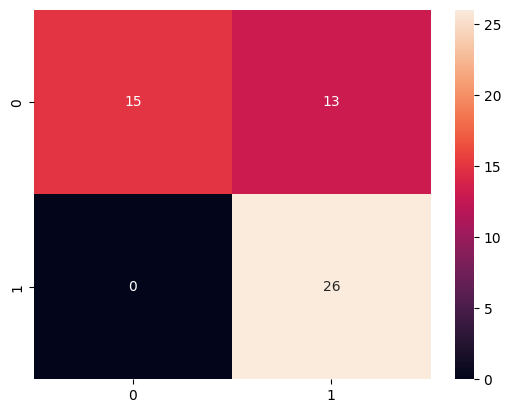

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

In [42]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70        28
           1       0.67      1.00      0.80        26

    accuracy                           0.76        54
   macro avg       0.83      0.77      0.75        54
weighted avg       0.84      0.76      0.75        54



## Fine Tuning

In [43]:
base_model.trainable = True

In [44]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True> F

In [45]:
#choose some layers to unfreeye the weights
len(base_model.layers)

175

In [46]:
fine_tune_at = 140 # choose to freeze the last convolutional layers
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [47]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True> F

In [48]:
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
history = network.fit(train_dataset, epochs=10)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 273ms/step - accuracy: 0.7289 - loss: 0.5405
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.7574 - loss: 0.4525
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.7630 - loss: 0.4382
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.7783 - loss: 0.5204
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.7933 - loss: 0.4354
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.7316 - loss: 0.5099
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.8219 - loss: 0.4382
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8005 - loss: 0.4344
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.8187 - loss: 0.4129
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.8078 - loss: 0.4697 


### Evaluating

In [50]:
predictions = network.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


In [51]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.8148148148148148

<Axes: >

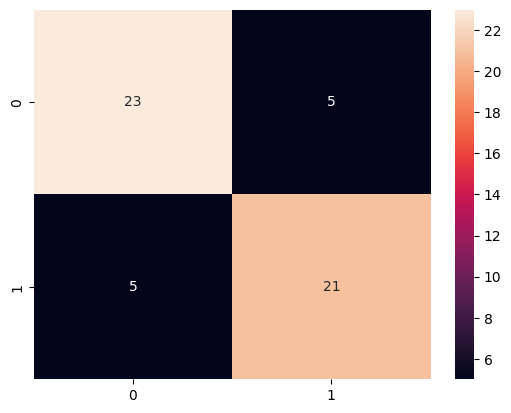

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

In [53]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.81      0.81      0.81        26

    accuracy                           0.81        54
   macro avg       0.81      0.81      0.81        54
weighted avg       0.81      0.81      0.81        54



### Saving and loading the model

In [54]:
model_json = network.to_json()
with open('model.json', 'w') as json_file:
  json_file.write(model_json)

In [56]:
from keras.models import save_model
network_saved = save_model(network, 'weights.hdf5')

In [57]:
with open('model.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"module": "keras.src.models.functional", "class_name": "Functional", "config": {"name": "functional", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "name": "input_layer"}, "registered_name": null, "name": "input_layer", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "registered_name": null, "build_config": {"input_shape": [null, 256, 256, 3]}, "name": "conv1_pad", "inbound_nodes": [{"args": [{"class_name": "__keras_tensor__", "config": {"shape": [null, 256, 256, 3], "dtype": "float32", "keras_history": ["input_layer", 0, 0]}}], "kwargs": {}}]}, {"module": "keras.layers", "class_name": "Conv2D", "config": {

In [58]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
network_loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,741,639 (102.01 MB)

 Trainable params: 3,153,927 (12.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Classifying one single image

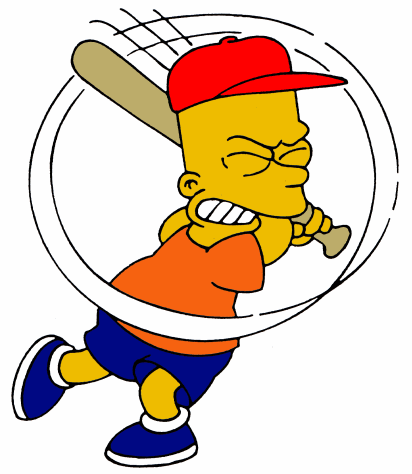

In [62]:
image = cv2.imread('/content/homer_bart_2/test_set/bart/bart15.bmp')
cv2_imshow(image)

In [63]:
image = cv2.resize(image, (256,256))
image.shape


(256, 256, 3)

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]], dtype=uint8)
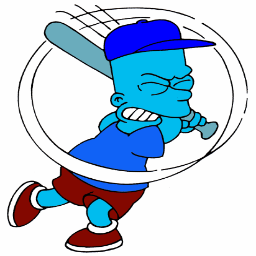

In [64]:
image

In [65]:
image = image.reshape(-1,256,256,3)
image.shape

(1, 256, 256, 3)

In [66]:
result = network_loaded.predict(image)
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array([[0.85067385, 0.14932613]], dtype=float32)

In [67]:
result = np.argmax(result, axis=1)
result

array([0])

In [68]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [70]:
if result == 0:
  print('Bart')
else:
  print('Homer')

Bart
